<a href="https://colab.research.google.com/github/devkyle4/ASR_Task/blob/main/UG_asr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dropbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.0/594.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.6/158.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.3 MB/s eta 0:00:00


In [2]:
import os
import io
import sys
import torch
import dropbox
import torchaudio
import numpy as np
import pandas as pd
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T
from torchvision import transforms
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

In [3]:
from torch.utils.data import random_split

In [4]:
!pip freeze > requirements.txt

In [5]:
from google.colab import userdata
dbx_token = userdata.get('dbx_token')
dbx = dropbox.Dropbox(dbx_token)

In [6]:
# STREAM DATA FROM DROPBOX

def stream_data_from_dropbox(path):
  _, res = dbx.files_download(path)
  data = io.BytesIO(res.content)
  return data

In [7]:
audio_transcript_path="/Akan/selected transcribed audios/selected transcribed audios.xlsx"
audio_transcript_data = stream_data_from_dropbox(audio_transcript_path)
transcribed_audios_df = pd.read_excel(audio_transcript_data)

In [8]:
def avg_wer(wer_scores, combined_ref_len):
  return float(sum(wer_scores)) / float(combined_ref_len)

def levenshtein_distance(ref, hyp):
  m = len(ref)
  n = len(hyp)

  # Special Case
  if ref == hyp:
    return 0
  if m == 0:
    return n
  if n == 0:
    return m

  if m<n:
    ref, hyp = hyp, ref
    m, n = n, m


  distance = np.zeros((2, n+1), dtype=np.int32)

  # initialize distance matrix
  for j in range(0,n + 1):
      distance[0][j] = j

  # calculate levenshtein distance
  for i in range(1, m + 1):
      prev_row_idx = (i - 1) % 2
      cur_row_idx = i % 2
      distance[cur_row_idx][0] = i
      for j in range(1, n + 1):
          if ref[i - 1] == hyp[j - 1]:
              distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
          else:
              s_num = distance[prev_row_idx][j - 1] + 1
              i_num = distance[cur_row_idx][j - 1] + 1
              d_num = distance[prev_row_idx][j] + 1
              distance[cur_row_idx][j] = min(s_num, i_num, d_num)

  return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False):
    if ignore_case == True:
        reference = reference
        hypothesis = hypothesis

    ref_words = reference
    hyp_words = hypothesis

    edit_distance = levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, remove_space=False):
    join_char = ' '
    if remove_space == True:
        join_char = ''


    if isinstance(reference, list):
      reference = join_char.join(filter(None,reference[0].values()))
    else:
        reference = join_char.join(filter(None, reference))

    # if isinstance(hypothesis, list):
    #   hypothesis = join_char.join(filter(None,hypothesis[0].values()))
    # else:
    #   hypothesis = join_char.join(filter(None, hypothesis))

    edit_distance = levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, delimiter=' '):
    edit_distance, ref_len = word_errors(reference, hypothesis,
                                         delimiter)
    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, remove_space=False):
    edit_distance, ref_len = char_errors(reference, hypothesis,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [9]:
# def text_to_sequence(text, vocabularies):
#   return [vocabularies.get(char, vocabularies['<unk>']) for char in text]

In [10]:
def build_vocab(transcripts):
  unique_chars = set(''.join(transcripts))

  char_to_id = {char: id + 1 for id, char in enumerate(sorted(unique_chars))}
  char_to_id['<pad>'] = 0  # Padding token
  char_to_id['<sos>'] = len(char_to_id)  # Start of sequence token
  char_to_id['<eos>'] = len(char_to_id)  # End of sequence token
  char_to_id['<unk>'] = len(char_to_id)  # Unknown token, for characters not in the vocabulary

  return char_to_id

vocab = build_vocab(transcribed_audios_df['Transcriptions'])

In [11]:
class TransformText:
  def __init__(self, vocab):
    self.vocab = vocab
    self.char_map = {}
    self.index_map = {}

    for ch, idx in vocab.items():
      self.char_map[ch] = int(idx)
      self.index_map[idx] = ch


  # CHANGING TEXT TO INT SEQUENCE
  def text_to_int_seq(self, text):
    int_sequence = []

    for char in text:
      char = self.char_map[char]
      int_sequence.append(char)
    return int_sequence


  def int_to_text(self, labels):
    string = []

    for i in labels:
      string.append(self.index_map)
    return string


text_transform = TransformText(vocab)

In [12]:
class MyDataset(Dataset):
  def __init__(self, metadata_df, dbx_client):

    self.metadata_df = metadata_df
    self.dbx_client = dbx_client


  def __len__(self):
    return len(self.metadata_df)


  def __getitem__(self, idx):
    item = self.metadata_df.iloc[idx]

    audio_path = '/Akan/selected transcribed audios/audios/' + item['Full Filename'].lstrip('/')

    # STREAM AUDIO
    _, audio_res = self.dbx_client.files_download(path= audio_path)
    signal, sample_rate = torchaudio.load(io.BytesIO(audio_res.content))

    # CONVERTING STEREO AUDIO TO MONO
    if signal.shape[0] == 2:
      signal = torch.mean(signal, dim=0, keepdim=True)

    transcript = item['Transcriptions']


    return signal, transcript

In [13]:
def data_processing(data):
  sample_rate = 44100
  mfccs = []
  labels = []
  input_lengths = []
  label_lengths = []

  #FEATURE EXTRACTION
  mcfcc_transformer = T.MFCC(sample_rate=sample_rate, n_mfcc=13,
  melkwargs={
      "n_fft": 2048,
      "hop_length": 512,
      "n_mels": 40,
  })

  for (signal, transcript) in data:
    mfcc = mcfcc_transformer(signal).squeeze(0).transpose(0, 1)
    # NORMALIZE WAVEFORM
    mfcc = (mfcc - mfcc.mean()) / mfcc.std()
    mfccs.append(mfcc)
    label = torch.Tensor(text_transform.text_to_int_seq(transcript))
    labels.append(label)
    input_lengths.append(mfcc.shape[0]//2)
    label_lengths.append(len(label))

  mfccs = pad_sequence(mfccs, batch_first=True).unsqueeze(1).transpose(2, 3)
  labels = pad_sequence(labels, batch_first=True, padding_value=0.0)

  return mfccs, labels, input_lengths, label_lengths

In [14]:
#USING ONLY 1000 OF THE DATASET BECAUSE STREAMING ALL THE DATA IS INEFFICIENT
# akan_dataset = MyDataset(transcribed_audios_df[:1000], dbx)
akan_dataset = MyDataset(transcribed_audios_df[:500], dbx)

In [15]:
# USING ONLY 4 INSTANCES OF THE DATASET FOR TESTING PURPOSES
ds = [akan_dataset.__getitem__(4+i) for i in range(4)]

#### **Splitting Dataset into Train, Test and Validation Set**

In [16]:
random_seed = 42
torch.manual_seed(random_seed)

In [17]:
dataset_size = len(akan_dataset)
train_size = int(0.5*dataset_size)
test_size = int((dataset_size - train_size)*0.5)
val_size = int(dataset_size - train_size - test_size)

train_ds, test_ds, val_ds = random_split(akan_dataset, [train_size, test_size, val_size])

In [18]:
# DECODES THE OUTPUT OF THE PREDICTION
def GreedyDecoder(output, labels, label_lengths, blank_label=92, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	# print(f'arg_maxes Shape: {arg_maxes}')

	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		# print(f'i: {i} & args: {args}')
		targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			# print(f'j: {j} & index: {index}')
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue
				decode.append(index.item())
		decodes.append(text_transform.int_to_text(decode))
	return decodes, targets

## **Model Building**

### **Deep 2 Search Architecture**

In [19]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
      # x (batch, channel, feature, time)
      x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
      x = self.layer_norm(x)
      return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)

In [20]:
class ResidualCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel,
                              stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel,
                              stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

In [21]:
class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

class SpeechRecognitionModel(nn.Module):

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2 + 1
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2) # cnn for extracting hierarchical features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
      x = self.cnn(x)
      x = self.rescnn_layers(x)
      sizes = x.size()
      x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
      x = x.transpose(1, 2) # (batch, time, feature)
      x = self.fully_connected(x)
      x = self.birnn_layers(x)
      x = self.classifier(x)

      return x

In [22]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


# Track loss and accuracy during training and testing
train_losses = []
test_losses = []
test_accuracies = []

def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter):
    model.train()
    data_len = len(train_loader.dataset)
    total_loss = 0  # Track total loss during an epoch
    for batch_idx, _data in enumerate(train_loader):

      mfcc, labels, input_lengths, label_lengths = _data
      mfcc, labels = mfcc.to(device), labels.to(device)

      optimizer.zero_grad()

      output = model(mfcc)  # (batch, time, n_class)
      output = F.log_softmax(output, dim=2)
      output = output.transpose(0, 1) # (time, batch, n_class)


      loss = criterion(output, labels, input_lengths, label_lengths)
      loss.backward()


      optimizer.step()
      scheduler.step()
      iter_meter.step()
      if batch_idx % 100 == 0 or batch_idx == data_len:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(mfcc), data_len,
              100. * batch_idx / len(train_loader), loss.item()))

    # Calculate average loss for the epoch and append to list
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)




def test(model, device, test_loader, criterion, epoch, iter_meter):
  try:
    print('\nevaluating…')
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
      for i, _data in enumerate(test_loader):
        mfcc, labels, input_lengths, label_lengths = _data
        mfcc, labels = mfcc.to(device), labels.to(device)

        output = model(mfcc)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        test_loss += loss.item() / len(test_loader)

        decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)

        for j in range(len(decoded_preds)):
            test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
            test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

            # Calculate accuracy
            if decoded_preds[j] == decoded_targets[j]:
                correct += 1
            total += 1



    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    accuracy = correct / total
    test_accuracies.append(accuracy)


  except Exception as e:
    print(f'Error processing batch {i}: {e}')

  # Calculate average loss for the epoch and append to list
  avg_loss = test_loss / len(test_loader)
  test_losses.append(avg_loss)



  print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))

In [23]:
def plot_loss_and_accuracy(train_losses, test_losses, test_accuracies):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.show()

In [24]:
def main(learning_rate, batch_size, epochs, train_ds, valid_ds):

    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 93,
        "n_feats": 13,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")

    # Creating DataLoaders for the Train, Test and Validation Datasets
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = DataLoader(dataset=train_ds,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x),
                                **kwargs)
    test_loader = DataLoader(dataset=test_ds,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x),
                                **kwargs)


    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)


    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=92).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'],
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=hparams['epochs'],
                                            anneal_strategy='linear')

    iter_meter = IterMeter()
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter)
        test(model, device, test_loader, criterion, epoch, iter_meter)


    # Plot loss and accuracy curves
    plot_loss_and_accuracy(train_losses, test_losses, test_accuracies)

In [25]:
learning_rate = 5e-4
batch_size = 1
epochs = 1

Train Epoch: 1 [0/250 (0%)]	Loss: 15.932313
Train Epoch: 1 [100/250 (40%)]	Loss: 3.085648
Train Epoch: 1 [200/250 (80%)]	Loss: 2.966272

evaluating…
Test set: Average loss: 3.0216, Average CER: 1.000000 Average WER: 1.0000



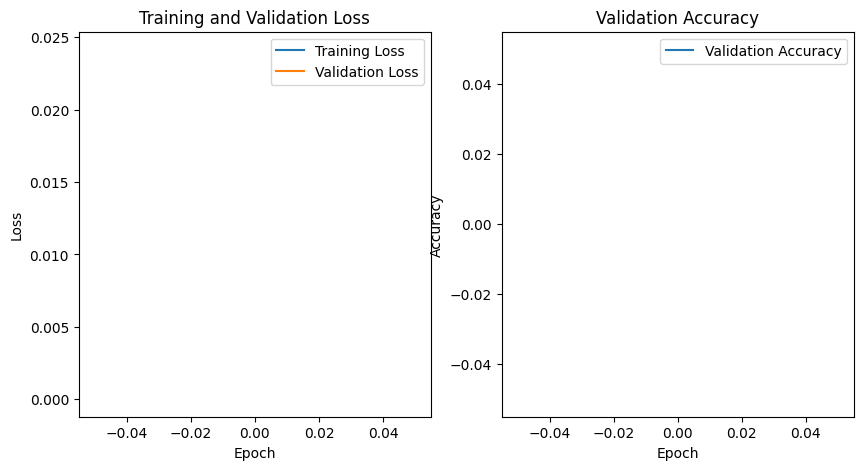

In [26]:
main(learning_rate, batch_size, epochs, train_ds, test_ds)